In [1]:
import numpy as np
import control as ctrl
import matplotlib.pyplot as plt

In [2]:
# Parametros del sistema
M = 0.5
m = 0.2
b = 0.1
I = 0.006
g = 9.8
l = 0.3

In [3]:
p = I*(M+m)+M*m*l**2 # denominator for the A and B matrices

A = np.array([[0, 1, 0, 0],
     [0, -(I+m*l**2)*b/p, (m**2*g*l**2)/p, 0],
     [0, 0, 0, 1],
     [0, -(m*l*b)/p, m*g*l*(M+m)/p, 0]])

B = np.array([[0],
             [(I+m*l**2)/p],
             [0],
             [m*l/p]])

#C = np.array([[1, 0, 0, 0],
#              [0, 0, 1, 0]])

C = np.array([1, 0, 0, 0])

inv_pend_ss = ctrl.StateSpace(A, B, C, 0)
inv_pend_ss

StateSpace(array([[ 0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.        , -0.18181818,  2.67272727,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ],
       [ 0.        , -0.45454545, 31.18181818,  0.        ]]), array([[0.        ],
       [1.81818182],
       [0.        ],
       [4.54545455]]), array([[1., 0., 0., 0.]]), array([[0.]]))

In [4]:
eigenvalues = np.linalg.eigvals(A)
eigenvalues

array([ 0.        , -0.14283164, -5.60409413,  5.56510758])

/home/belphegor/.local/lib/python3.11/site-packages/control/timeresp.py:1197: RuntimeWarning: overflow encountered in matmul
  xout[:, i] = (Ad @ xout[:, i-1]
/home/belphegor/.local/lib/python3.11/site-packages/control/timeresp.py:1197: RuntimeWarning: invalid value encountered in matmul
  xout[:, i] = (Ad @ xout[:, i-1]
/home/belphegor/.local/lib/python3.11/site-packages/control/timeresp.py:1199: RuntimeWarning: invalid value encountered in matmul
  yout = C @ xout + D @ U


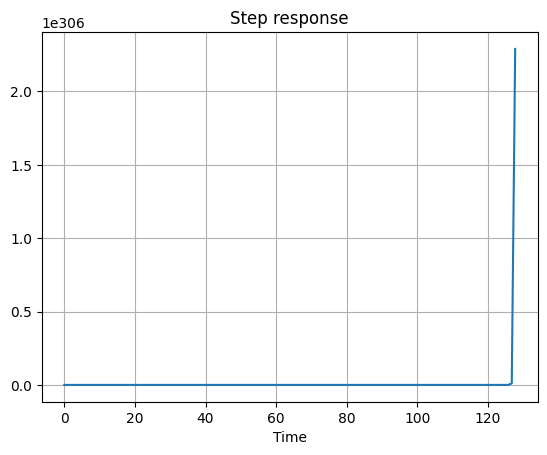

In [50]:
# Respuesta ante una entrada de tipo 'step'
t, yout, x = ctrl.step_response(inv_pend_ss, return_x = True)

plt.figure()
plt.plot(t, yout)
plt.title('Step response')
plt.xlabel('Time')
plt.grid('minor')
plt.show()

In [51]:
# Eigenvalores del sistema en lazo cerrado
print(np.linalg.eigvals(A - B*C))

[-5.56889856+0.j         5.53331025+0.j        -0.07311493+1.2001072j
 -0.07311493-1.2001072j]


In [52]:
inv_pend_ss_cl = ctrl.feedback(sys1=inv_pend_ss, sys2=1, sign=-1)
inv_pend_ss_cl

StateSpace(array([[ 0.        ,  1.        ,  0.        ,  0.        ],
       [-1.81818182, -0.18181818,  2.67272727,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ],
       [-4.54545455, -0.45454545, 31.18181818,  0.        ]]), array([[0.        ],
       [1.81818182],
       [0.        ],
       [4.54545455]]), array([[1., 0., 0., 0.]]), array([[0.]]))

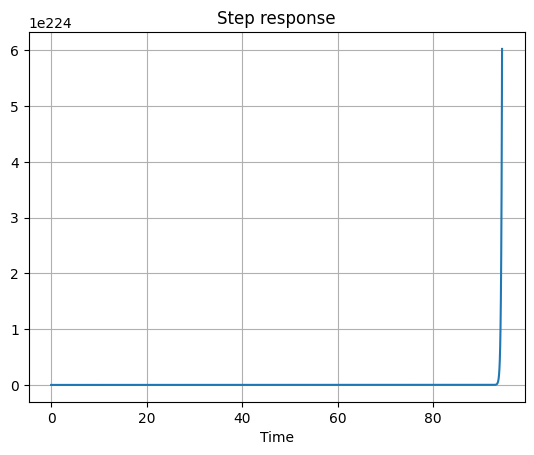

In [54]:
# Respuesta ante una entrada de tipo 'step' para el sistema en lazo cerrado
t_cl, yout_cl, x_cl = ctrl.step_response(inv_pend_ss_cl, return_x = True)

plt.figure()
plt.plot(t_cl, yout_cl)
plt.title('Step response')
plt.xlabel('Time')
plt.grid('minor')
plt.show()


In [55]:
def get_kr(sys, K):
    """
     This function finds the scale factor kr which will
     eliminate the steady-state error to a step reference.
     
                               /---------\
           ref       +     u  | .       |
          ---> kr --->() ---->| X=Ax+Bu |--> y=Cx ---> y
                     -|       \---------/
                      |             | 
                      |<---- K <----|

    Parameters
    ----------
    sys : StateSpace of a linear system
        SISO continuous-time using ctrl.ss().
    K : Vector of dimension [1xn]
        Feedback vector K.

    Returns
    -------
    Array of float64
        Scale factor kr.

    """
    s = sys.A.shape[0]
    Z = np.hstack((np.zeros((1,s)), [[1]]))
    N = np.dot(np.linalg.inv(np.vstack((np.hstack((sys.A, sys.B)), np.hstack((sys.C, sys.D))))), Z.T)
    Nx = N[0:s]
    Nu = N[s]
    return Nu + np.dot(K,Nx)

In [56]:
# Eigenvalores deseados
eig_d = np.array([-5.56889856, -5.53331025, -5.07311493, -5.7311493])

K = ctrl.place(A, B, eig_d)
K

array([[-20.11256021, -14.82028212,  54.4699165 ,  10.70753692]])

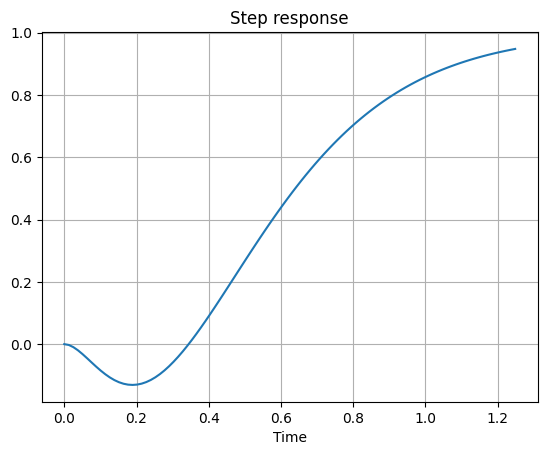

In [57]:
kr = get_kr(inv_pend_ss, K)

Acl = A - B*K
Bcl = kr*B

# Respuesta ante una entrada de tipo 'step' para el sistema en lazo cerrado
inv_pend_ss_cl_K = ctrl.ss(Acl, Bcl, C, 0)
t_cl, yout_cl, x_cl = ctrl.step_response(inv_pend_ss_cl_K, return_x = True)

plt.figure()
plt.plot(t_cl, yout_cl)
plt.title('Step response')
plt.xlabel('Time')
plt.grid('minor')
plt.show()


In [58]:
ctrl.step_info(inv_pend_ss_cl_K)

{'RiseTime': 0.6809425723216889,
 'SettlingTime': nan,
 'SettlingMin': 0.9026879173727034,
 'SettlingMax': 1.0,
 'Overshoot': 0,
 'Undershoot': 13.088082703818088,
 'Peak': 0.9476601052878864,
 'PeakTime': 1.2483947159230964,
 'SteadyStateValue': 1.0}